In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Glen's beam from Yunhai's 3D paper

In [2]:
# Glen's beam, which comes from Yunhai's 3D CSR paper!

gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2



# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread


# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

### Yunhai's beam for transient wakes

In [2]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

# Code

In [3]:
from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes_case_A, green_meshes_case_B, green_meshes_case_C
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

# phi is the entrance angle of the bunch center
def csr2d_kick_calc_case_C(
    z_b, x_b, weight, *,
    gamma=None, rho=None, phi_m = None, exit_distance=None, x_observe = None,
    nz=100, nx=100,
    xlim=None, zlim=None, reuse_psi_grids=False, psi_s_grid_old=None, psi_x_grid_old=None,
    map_f=map, species="electron", imethod='map_coordinates', debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    ## lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    lamb = exit_distance/rho
    
    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        #psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
        #Es_case_B_grid, zvec2, xvec2 = green_meshes_case_B(nz, nx, dz, dx, rho=rho, beta=beta) 
        #Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
        Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_C(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi_m/2, lamb=lamb) 
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    #conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    #conv_s_case_B = fftconvolve2(lambda_grid_filtered, Es_case_B_grid)[0]  # [0] required is there is only one grid
    #conv_s_case_A, conv_x_case_A = fftconvolve2(lambda_grid_filtered, Es_case_A_grid, Fx_case_A_grid) 
    
    #if debug:
    #    t5 = time.time()
    #    print("Convolution takes:", t5 - t4, "s")

    #Ws_case_B_grid = (beta**2 / rho**2) * (conv_s_case_B) * (dz * dx)
    #Ws_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_s_case_A) * (dz * dx)
    #Wx_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_x_case_A) * (dz * dx)
    ##Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    
    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zid_vec = rho*(phi_m + lamb - beta*np.sqrt(lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
    #zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)  

    # Want "True" if (z < zi), where the potential grid values are set to ZERO
    condition_grid = np.array([(zvec2 < zid_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded)
  
    Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
    Wx_grid = (1/gamma**2 / rho**2) * (conv_x) * (dz*dx)
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    
    return zvec,xvec,Ws_grid[:,x_observe_index]
    
    #return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_grid, dz, dx

In [16]:
#np.savetxt("phi_0.01_wake.dat", wake_listA[1][2])
#np.savetxt("phi_0.1_wake.dat", wake_listA[5][2])

In [4]:
x_observe = 0.0

#phi_vec = [0.0045, 0.005, 0.006, 0.01, 0.02, 0.03]
#phi_vec = [0.0666667]

exit_distance_vec = [0.01,0.02,0.03,0.04,0.05,0.06]

ffC = lambda a : csr2d_kick_calc_case_C(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi_m = 0.1/rho, exit_distance = a, x_observe = 0,
    nz=600, nx=500, debug=True)
wake_listC = np.array(list(map(ffC, exit_distance_vec)))

Depositing particles takes: 0.7069852352142334 s
Computing potential grids take: 0.22264742851257324 s
Depositing particles takes: 0.0188901424407959 s
Computing potential grids take: 0.21274352073669434 s
Depositing particles takes: 0.01578831672668457 s
Computing potential grids take: 0.2001795768737793 s
Depositing particles takes: 0.013426780700683594 s
Computing potential grids take: 0.19898223876953125 s
Depositing particles takes: 0.013617753982543945 s
Computing potential grids take: 0.20200371742248535 s
Depositing particles takes: 0.02182769775390625 s
Computing potential grids take: 0.19804644584655762 s


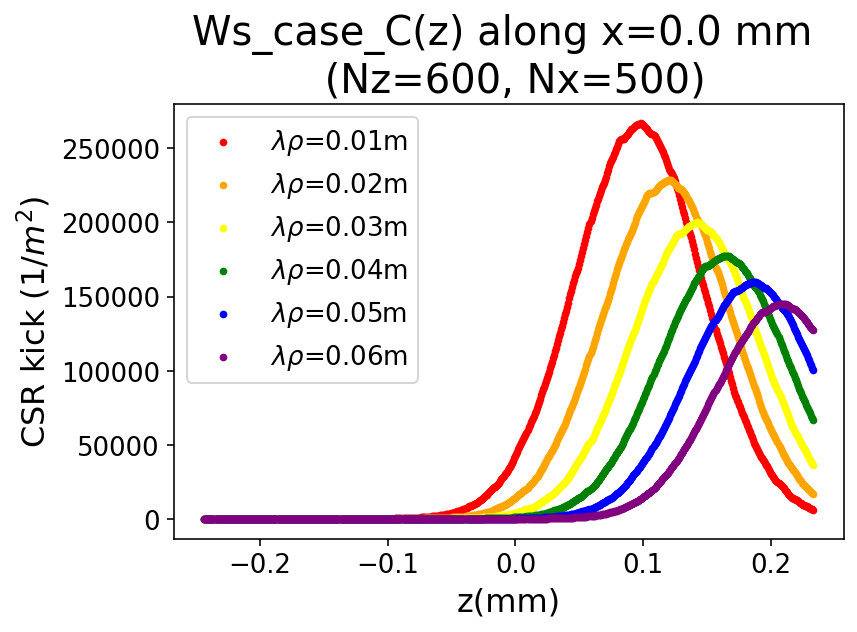

In [6]:
zvec = wake_listC[0][0]
zvec.size

plt.scatter(zvec*10**3,wake_listC[0][2], color='red', label=r'$\lambda \rho$='+str(exit_distance_vec[0])+'m', s=8 )
plt.scatter(zvec*10**3,wake_listC[1][2], color='orange', label=r'$\lambda \rho$='+str(exit_distance_vec[1])+'m', s=8    )
plt.scatter(zvec*10**3,wake_listC[2][2], color='yellow', label=r'$\lambda \rho$='+str(exit_distance_vec[2])+'m', s=8    )
plt.scatter(zvec*10**3,wake_listC[3][2], color='green', label=r'$\lambda \rho$='+str(exit_distance_vec[3])+'m', s=8    )
plt.scatter(zvec*10**3,wake_listC[4][2], color='blue', label=r'$\lambda \rho$='+str(exit_distance_vec[4])+'m', s=8    )
plt.scatter(zvec*10**3,wake_listC[5][2], color='purple', label=r'$\lambda \rho$='+str(exit_distance_vec[5])+'m', s=8    )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws_case_C(z) along x='+str(x_observe*1000)+' mm \n (Nz=600, Nx=500)',  fontsize=20)
plt.legend()

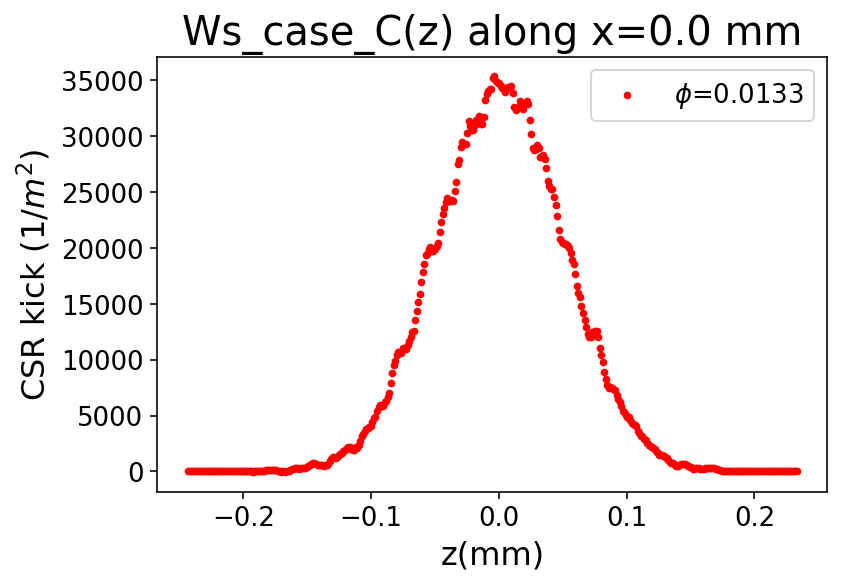

In [34]:
# Benchmarking with Yunhai's slide

zvec = wake_listC[0][0]
zvec.size

plt.scatter(zvec*10**3,wake_listC[0][2], color='red', label='$\phi$='+str(exit_distance_vec[0]), s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws_case_C(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

# Testing to map over x_observe

In [11]:
from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes_case_A, green_meshes_case_B
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

# phi is the entrance angle of the bunch center
def csr2d_kick_calc_test(
    z_b, x_b, weight, *,
    gamma=None, rho=None, phi = None, x_observe = None,
    nz=100, nx=100,
    xlim=None, zlim=None, reuse_psi_grids=False, psi_s_grid_old=None, psi_x_grid_old=None,
    map_f=map, species="electron", imethod='map_coordinates', debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    ## lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        #psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
        #Es_case_B_grid, zvec2, xvec2 = green_meshes_case_B(nz, nx, dz, dx, rho=rho, beta=beta) 
        Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    #conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    #conv_s_case_B = fftconvolve2(lambda_grid_filtered, Es_case_B_grid)[0]  # [0] required is there is only one grid
    #conv_s_case_A, conv_x_case_A = fftconvolve2(lambda_grid_filtered, Es_case_A_grid, Fx_case_A_grid) 
    
    #if debug:
    #    t5 = time.time()
    #    print("Convolution takes:", t5 - t4, "s")

    #Ws_case_B_grid = (beta**2 / rho**2) * (conv_s_case_B) * (dz * dx)
    #Ws_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_s_case_A) * (dz * dx)
    #Wx_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_x_case_A) * (dz * dx)
    ##Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    ############################
    #conv_s = conv_with_boundary(x_observe=x_observe, phi=phi, rho=rho, zvec2=zvec2, xvec2=xvec2, xvec=xvec, lambda_or_lambdap_grid=lambda_grid_filtered, potential_or_field_grid= Es_grid_bounded)
    
    ###### To be replaced #################
    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)  

    # Want "True" if (z < zi), where the potential grid values are set to ZERO
    condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded)
  
    ##########################################
    
    ##x_observe_index = np.argmin(np.abs(xvec - x_observe))
    Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
    #Wx_grid = (1/gamma**2 / rho**2) * (conv_x) * (dz*dx)
    
    
    
    #return zvec,xvec,Ws_grid[:,x_observe_index]
    
    #return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_grid, dz, dx
    
    
    return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_grid_bounded, dz, dx

In [12]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_grid_bounded, dz, dx= csr2d_kick_calc_test(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.01, x_observe = 0,
    nz=600, nx=500, debug=True)

Depositing particles takes: 0.015597343444824219 s
Computing potential grids take: 0.18059301376342773 s


In [5]:
def conv_with_boundary(x_observe=None, phi=None, rho=None, zvec2=None, xvec2=None, xvec=None, lambda_or_lambdap_grid=None, potential_or_field_grid=None):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)  

    # Want "True" if (z < zi), where the potential grid values are set to ZERO
    condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])
    potential_or_field_grid_bounded = np.where(condition_grid.T, 0, potential_or_field_grid)
    
    #Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    #Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

    conv = fftconvolve2(lambda_or_lambdap_grid, potential_or_field_grid_bounded)[0]
  
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    
    #Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
    #Wx_grid = (1/gamma**2 / rho**2) * (conv_x) * (dz*dx)
    
    return conv[:,x_observe_index]

In [55]:
conv_vec = lambda xx: conv_with_boundary(x_observe=xx, phi=0.01, rho=rho, zvec2=zvec2, xvec2=xvec2, xvec=xvec, lambda_or_lambdap_grid=lambda_grid_filtered, potential_or_field_grid= Es_grid_bounded)


In [60]:
gaga = np.array(list(map(conv_vec, xvec)))
gaga.shape

(500, 600)

In [ ]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    executor.map(conv_vec, xvec)

In [13]:
haha = conv_with_boundary(x_observe=0, phi=0.01, rho=rho, zvec2=zvec2, xvec2=xvec2, xvec=xvec, lambda_or_lambdap_grid=lambda_grid_filtered, potential_or_field_grid= Es_grid_bounded)